In [8]:
path1 = '/home/adboer/dlwp-benchmark/src/dlwpbench/outputs/unet_inverted_C2_hpx/evaluation/outputs.nc'
path2 = '/home/adboer/dlwp-benchmark/src/dlwpbench/outputs/unet_inverted/evaluation/outputs.nc'
era5 = '/home/adboer/dlwp-benchmark/src/dlwpbench/data/netcdf/weatherbench/msl/msl_2017_5.625deg.nc'
import xarray as xr

#weynC2 = xr.open_dataset(path1)
#weynC2hpx = xr.open_dataset(path2)
era5 = xr.open_dataset(era5)

In [9]:
var = 'msl'
era5 = compute_zonal_spectrum(era5, var).mean(dim='time')
#WC = compute_zonal_spectrum(weynC2, var).mean(dim='sample').mean(dim='time')
#WChpx = compute_zonal_spectrum(weynC2hpx, var).mean(dim='sample').mean(dim='time')

out <xarray.DataArray 'lat' (lat: 32)> Size: 256B
array([ 30673.56979012,  91725.30612541, 151893.67762056, 210599.22996669,
       267276.596603  , 321379.94350576, 372388.22586842, 419810.20604786,
       463189.18445145, 502107.39780381, 536190.04243549, 565108.88384723,
       588585.41778758, 606393.55240111, 618361.78561659, 624374.85680565,
       624374.85680565, 618361.78561659, 606393.55240111, 588585.41778758,
       565108.88384723, 536190.04243549, 502107.39780381, 463189.18445145,
       419810.20604786, 372388.22586842, 321379.94350576, 267276.596603  ,
       210599.22996669, 151893.67762056,  91725.30612541,  30673.56979012])
Coordinates:
  * lat      (lat) float64 256B -87.19 -81.56 -75.94 ... 75.94 81.56 87.19


In [36]:
diff = (era5 - WC) - (era5 - WChpx)

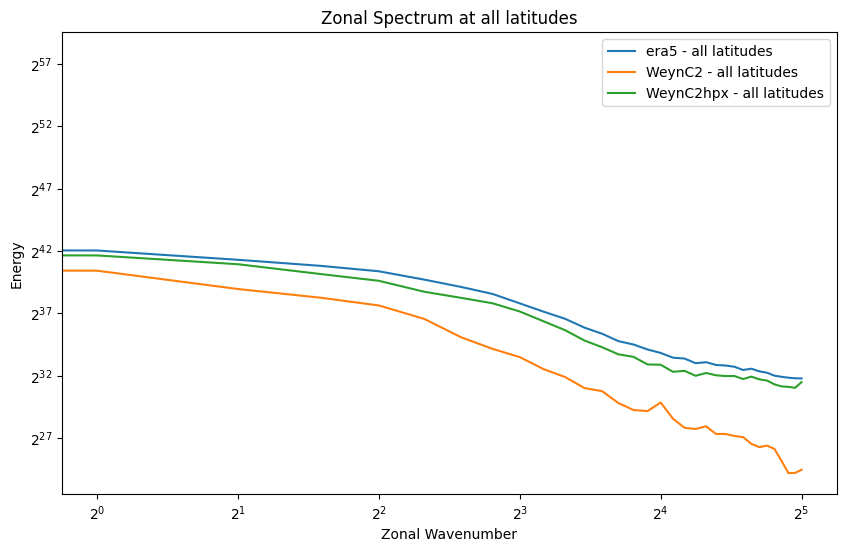

In [34]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 6))
# era5.mean('lat').plot(label='era5 - all latitudes')
# WC.mean('lat').plot(label ='WeynC2 - all latitudes')
# WChpx.mean('lat').plot(label='WeynC2hpx - all latitudes')
diff.mean('lat')).plot(label='Difference')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.legend(loc='upper right')
plt.title('Zonal Spectrum at all latitudes')
plt.xlabel('Zonal Wavenumber')
plt.ylabel('Energy')
plt.show()


In [6]:
import numpy as np
import xarray as xr

EARTH_RADIUS_M = 1000 * (6357 + 6378) / 2

class ZonalSpectrum:
    def __init__(self, variable_name: str | list[str]):
        self.variable_name = variable_name

    def _circumference(self, dataset: xr.Dataset) -> xr.DataArray:
        """Earth's circumference as a function of latitude."""
        circum_at_equator = 2 * np.pi * EARTH_RADIUS_M
        return np.cos(dataset.lat * np.pi / 180) * circum_at_equator

    def lon_spacing_m(self, dataset: xr.Dataset) -> xr.DataArray:
        """Spacing (meters) between longitudinal values in `dataset`."""
        diffs = dataset.lon.diff('lon')
        if np.max(np.abs(diffs - diffs[0])) > 1e-3:
            raise ValueError(
                f'Expected uniform longitude spacing. {dataset.lon.values=}'
            )
        out = self._circumference(dataset) * diffs[0].data / 360
        print('out', out)
        return out

    def compute(self, dataset: xr.Dataset) -> xr.DataArray:
        """Computes zonal power at wavenumber and frequency."""
        spacing = self.lon_spacing_m(dataset)

        def simple_power(f_x):
            f_k = np.fft.rfft(f_x, axis=-1, norm='forward')
            # freq > 0 should be counted twice in power since it accounts for both
            # positive and negative complex values.
            one_and_many_twos = np.concatenate(([1], [2] * (f_k.shape[-1] - 1)))
            return np.real(f_k * np.conj(f_k)) * one_and_many_twos

        spectrum = xr.apply_ufunc(
            simple_power,
            dataset,
            input_core_dims=[['lon']],
            output_core_dims=[['lon']],
            exclude_dims={'lon'},
        ).rename_dims({'lon': 'zonal_wavenumber'})[self.variable_name]

        spectrum = spectrum.assign_coords(
            zonal_wavenumber=('zonal_wavenumber', spectrum.zonal_wavenumber.data)
        )
        
        base_frequency = xr.DataArray(
            np.fft.rfftfreq(len(dataset.lon)),
            dims='zonal_wavenumber',
            coords={'zonal_wavenumber': spectrum.zonal_wavenumber},
        )
        
        spectrum = spectrum.assign_coords(frequency=base_frequency / spacing)
        spectrum['frequency'] = spectrum.frequency.assign_attrs(units='1 / m')

        spectrum = spectrum.assign_coords(wavelength=1 / spectrum.frequency)
        spectrum['wavelength'] = spectrum.wavelength.assign_attrs(units='m')

        # This last step ensures the sum of spectral components is equal to the
        # (discrete) integral of data around a line of latitude.
        return spectrum * self._circumference(spectrum)

def compute_zonal_spectrum(dataset: xr.Dataset, variable_name: str | list[str]) -> xr.Dataset:
    zonal_spectrum = ZonalSpectrum(variable_name)
    return zonal_spectrum.compute(dataset)
